# Basic Bayesian Linear Regression Implementation

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load in Exercise Data

In [2]:
exercise = pd.read_csv('data/exercise.csv')
calories = pd.read_csv('data/calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


# Plot Relationship

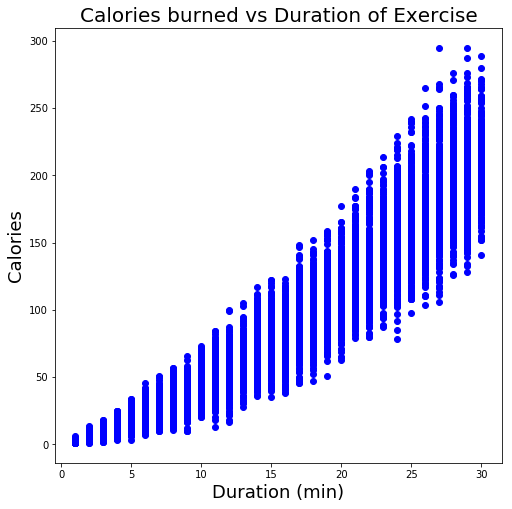

In [3]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [4]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.ix[:, 'Calories']

# Implement Ordinary Least Squares Linear Regression by Hand

In [5]:
# Takes a matrix of features (with intercept as first column) 
# and response vector and calculates linear regression coefficients
def linear_regression(X, y):
    # Equation for linear regression coefficients
    beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
    return beta

In [6]:
# Run the by hand implementation
by_hand_coefs = linear_regression(X, y)
print('Intercept calculated by hand:', by_hand_coefs[0])
print('Slope calculated by hand: ', by_hand_coefs[1])

Intercept calculated by hand: -21.82810252605084
Slope calculated by hand:  7.169783349587853


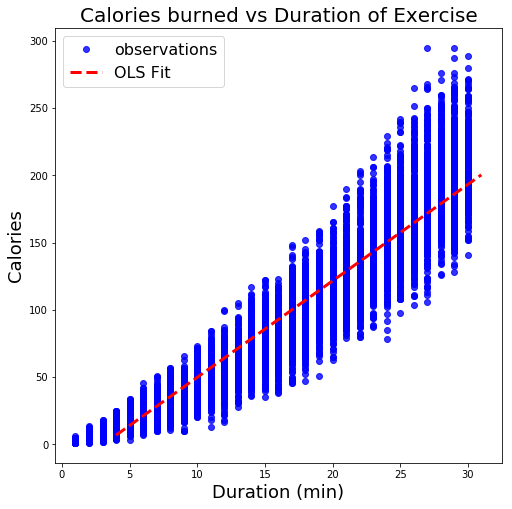

In [7]:
xs = np.linspace(4, 31, 1000)
ys = by_hand_coefs[0] + by_hand_coefs[1] * xs

plt.figure(figsize=(8, 8))
plt.plot(df['Duration'], df['Calories'], 'bo', label = 'observations', alpha = 0.8);
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.plot(xs, ys, 'r--', label = 'OLS Fit', linewidth = 3)
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

## Prediction for Datapoint

In [8]:
print('Exercising for 15.5 minutes will burn an estimated {:.2f} calories.'.format(
    by_hand_coefs[0] + by_hand_coefs[1] * 15.5))

Exercising for 15.5 minutes will burn an estimated 89.30 calories.


# Verify with Scikit-learn Implementation

In [9]:
# Create the model and fit on the data
lr = LinearRegression()
lr.fit(X.Duration.reshape(-1, 1), y)
print('Intercept from library:', lr.intercept_)
print('Slope from library:', lr.coef_[0])

Intercept from library: -21.828102526050813
Slope from library: 7.169783349587853


# Bayesian Linear Regression

### PyMC3 for Bayesian Inference

Implement MCMC to find the posterior distribution of the model parameters. Rather than a single point estimate of the model weights, Bayesian linear regression will give us a posterior distribution for the model weights.

## Model with 500 Observations

In [ ]:
with pm.Model() as linear_model_500:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[0:499, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values[0:500])
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_500 = pm.sample(1000, step)

## Model with all Observations

In [11]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, slope, Intercept]
The acceptance probability does not match the target. It is 0.9876388940291865, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9933390669386344, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


# Bayesian Model Results

The Bayesian Model provides more opportunities for interpretation than the ordinary least squares regression because it provides a posterior distribution. We can use this distribution to find the most likely single value as well as the entire range of likely values for our model parameters.

PyMC3 has many built in tools for visualizing and inspecting model runs. These let us see the distributions and provide estimates with a level of uncertainty, which should be a necessary part of any model.

## Trace of All Model Parameters

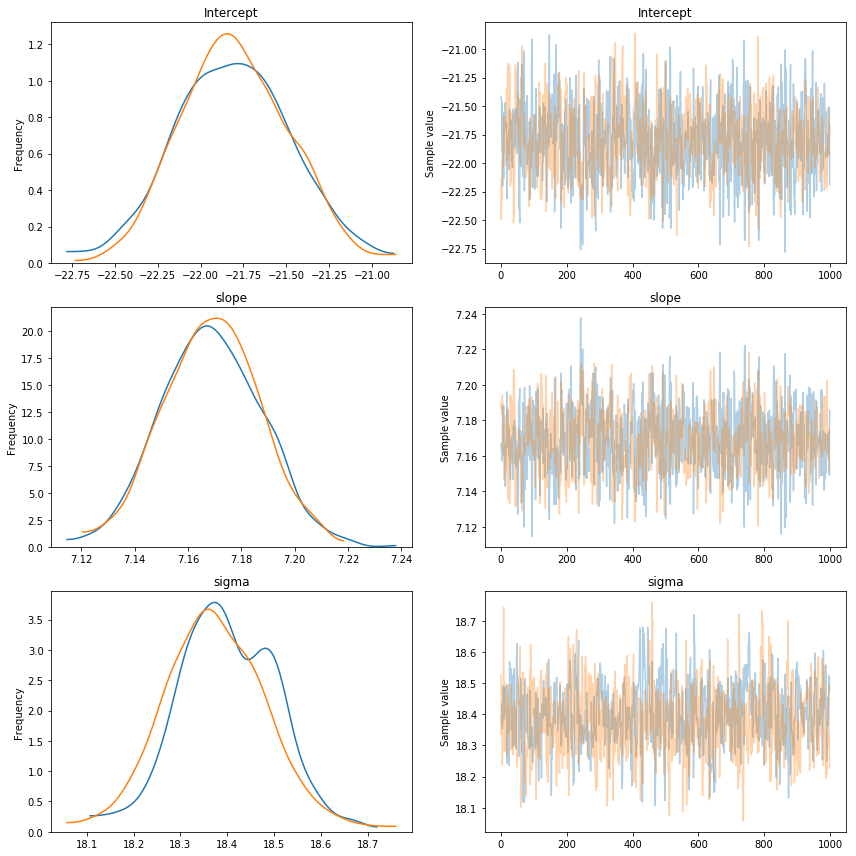

In [12]:
pm.traceplot(linear_trace, figsize = (12, 12));

## Posterior Distribution of Model Parameters

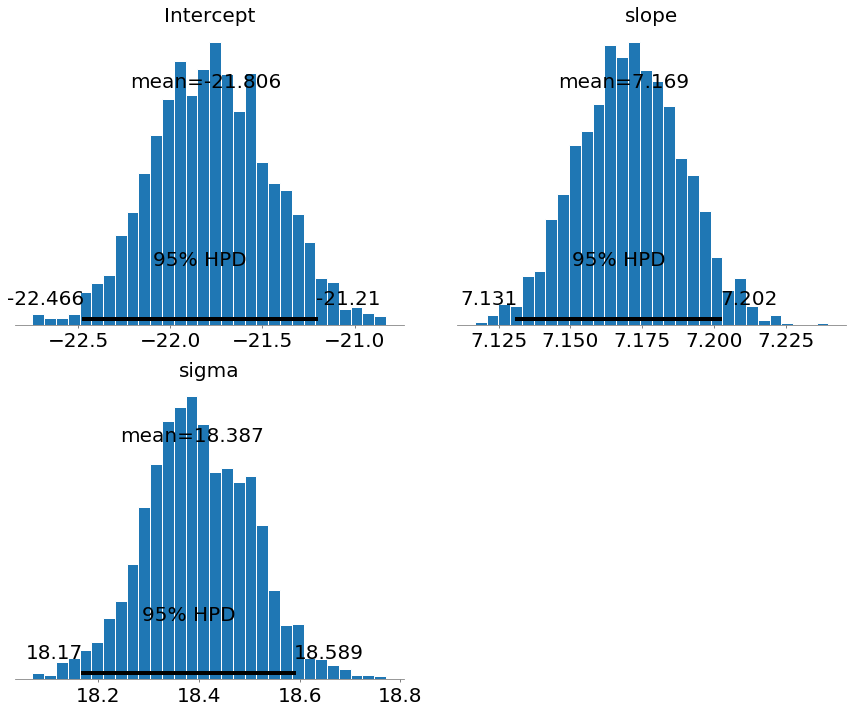

In [13]:
pm.plot_posterior(linear_trace, figsize = (12, 10), text_size = 20);

## Confidence Intervals for Model Parameters

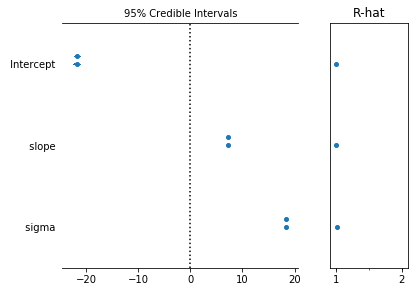

In [14]:
pm.forestplot(linear_trace);

# Predictions of Response Sampled from the Posterior

We can now generate predictions of the linear regression line using the model results. The following plot shows 1000 different estimates of the regression line drawn from the posterior. The distribution of the lines gives an estimate of the uncertainty in the estimate. Bayesian Linear Regression has the benefit that it gives us a posterior __distribution__ rather than a __single point estimate__ in the frequentist ordinary least squares regression.

## All Observations

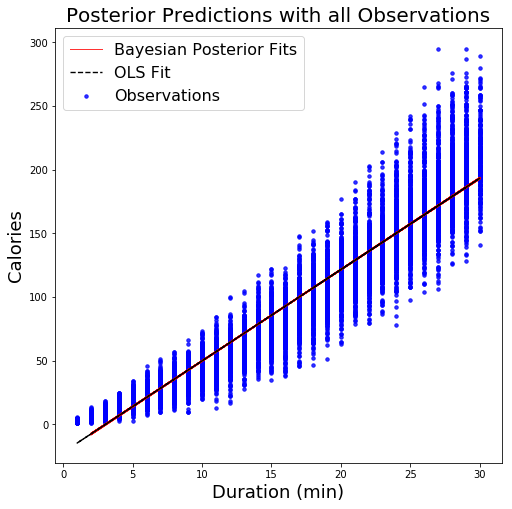

In [15]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [16]:
pm.df_summary(linear_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-21.805933,0.322550,0.011807,-22.465744,-21.209683,736.0,0.999821
slope,7.168752,0.018153,0.000681,7.131481,7.202292,707.0,0.999527
sigma,18.387170,0.106938,0.004344,18.169925,18.588937,426.0,1.012243


## Limited Observations

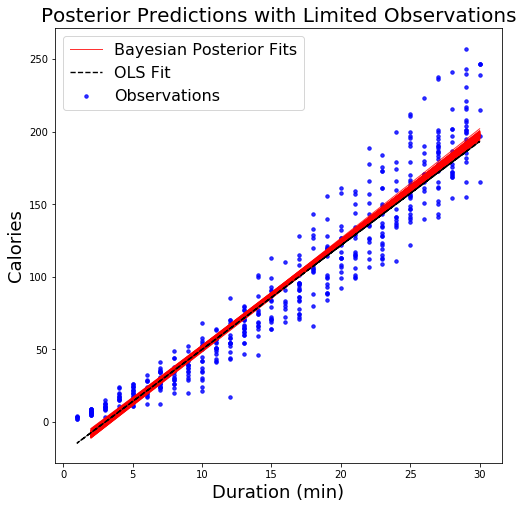

In [17]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'][:500], y.values[:500], s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with Limited Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [18]:
pm.df_summary(linear_trace_500)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-22.854865,1.776303,0.047775,-26.307522,-19.569343,1076.0,0.999589
slope,7.355138,0.097234,0.002733,7.171244,7.543756,1063.0,0.999530
sigma,18.206843,0.552285,0.016451,17.129418,19.296164,1083.0,1.002193


# Specific Prediction for One Datapoint

In [19]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 15.5

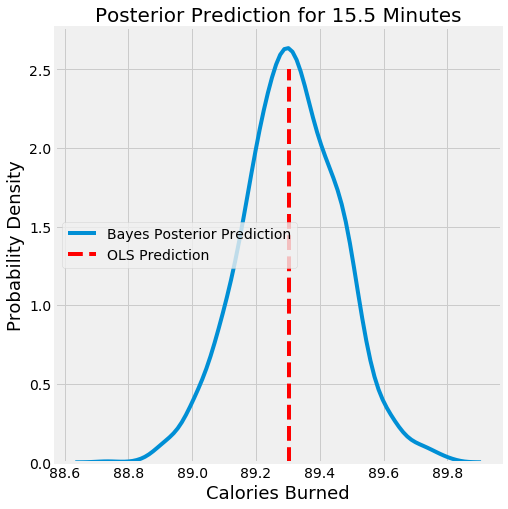

In [21]:
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = by_hand_coefs[0] + by_hand_coefs[1] * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);